In [49]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys 
sys.path.insert(0, "../src")
import configparser
import pandas as pd 

from utils.dice_score import multiclass_dice_coeff
import numpy as np
import torch
import matplotlib.pyplot as plt
from os.path import join as oj
import my_data
pd.set_option('display.float_format', lambda x: '%.3f' % x)
cuda = False # torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")
config = configparser.ConfigParser()
config.read('../config.ini');
data_path =config['DATASET']['data_path'] 


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
x,y, _, _ = my_data.load_layer_data(oj(data_path, 'lno'))
y_second, _, _ = my_data.load_reannotation(oj(data_path, 'lno_second_annotation'))
y_second_formatted = np.copy(y_second)
y_second_formatted_vals = np.unique(y_second_formatted)
for i,val in enumerate(y_second_formatted_vals):
    y_second_formatted[y_second == val] = i

<tifffile.TiffFile 'TrainSet_v2_secondAnnotation.tif'> ImageJ series metadata invalid or corrupted file


In [15]:
y_second_formatted = y_second_formatted[1024:, :1024] # only one quarter annotated
y = y[-1,1024:, :1024]

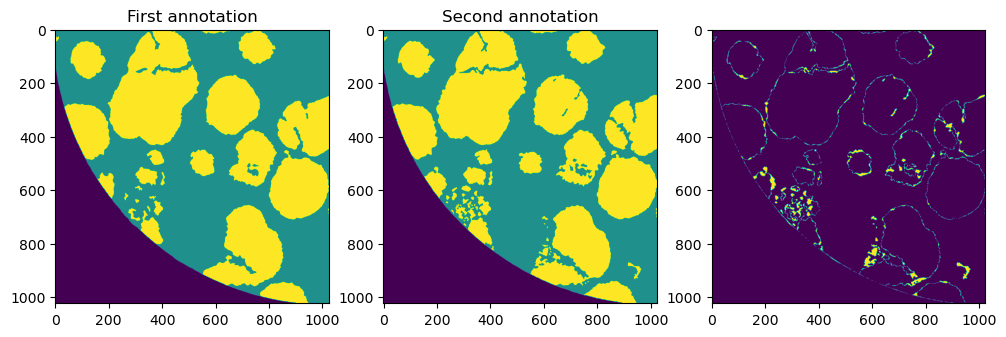

In [19]:
fig, axes = plt.subplots(ncols=3, figsize= (12,4))
axes[0].imshow(y)
# add title
axes[0].set_title('First annotation')
axes[1].imshow(y_second_formatted)

axes[1].set_title('Second annotation')
axes[2].imshow(y != y_second_formatted)

In [17]:
y_pred = y_second_formatted[None,:]
y_pred_one_hot = torch.nn.functional.one_hot(torch.Tensor(y_pred).to(torch.int64), 
                                            num_classes=3).permute(0, 3, 1, 2).squeeze()[None, :]


In [18]:
print(multiclass_dice_coeff(y_pred_one_hot.float(), 
                    torch.Tensor(y[None,:]), 
                    num_classes=3).item())


0.9761262536048889


In [63]:
# need exp with no active learning
# need exp with prop increasingf
import os
import pickle as pkl
fnames = sorted([oj(config['PATHS']['model_path'] , fname) for fname in os.listdir(config['PATHS']['model_path'] ) if "pkl" in fname]) 
results_list = [pd.Series(pkl.load(open(fname, "rb"))) for fname in (fnames)] 
results = pd.concat(results_list, axis=1).T.infer_objects()


results.reset_index(inplace=True)
results = results[results.experiment_name == 'AActiveLearning']
results[['foldername',  'cost_function', 'add_ratio',  'test_dice_score', 
         'experiment_name']].groupby([ 'experiment_name', 'cost_function','add_ratio', 
         'foldername' ]).mean()
results.reset_index(inplace=True)
my_file_name = results.file_name[results.final_dice_score.idxmax()]
# my_file_name = results.file_name[0]


In [64]:
# load a model and
from unet import UNet
net = UNet(1, 3, ).to(device)



net.load_state_dict(torch.load(oj(config['PATHS']['model_path'] , my_file_name +  ".pt" )))


<All keys matched successfully>

In [67]:
with torch.no_grad():
    img_t = torch.Tensor(x[-1:,:,1024:, :1024]/255.0).to(device)
    output = net.forward(img_t).cpu().detach().numpy()[0]

In [81]:
output.shape

(3, 1024, 1024)

In [84]:

y_pred_one_hot = torch.nn.functional.one_hot(torch.Tensor(output[None,:].argmax(1)).to(torch.int64), 
                                            num_classes=3).permute(0, 3, 1, 2).squeeze()[None, :]


In [85]:
print(multiclass_dice_coeff(y_pred_one_hot.float(), 
                    torch.Tensor(y[None,:]), 
                    num_classes=3).item())


0.8388710021972656


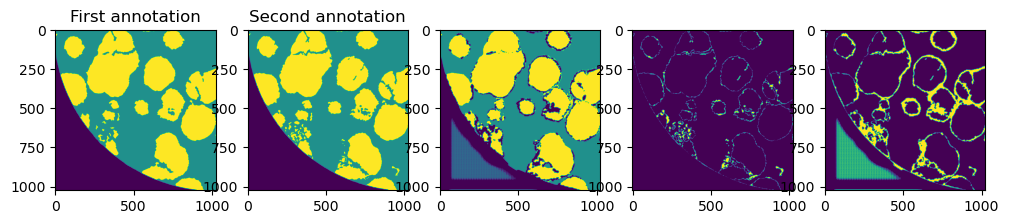

In [69]:
fig, axes = plt.subplots(ncols=5, figsize= (12,4))
axes[0].imshow(y)
# add title
axes[0].set_title('First annotation')
axes[1].imshow(y_second_formatted)

axes[1].set_title('Second annotation')
axes[3].imshow(y != y_second_formatted)


# axes[1].set_title('Second annotation')
axes[2].imshow(output.argmax(0))
axes[4].imshow(y_second_formatted != output.argmax(0))